In [188]:
import os
from textwrap import wrap
from typing import List

import pandas as pd
import numpy as np
from IPython.display import display
from joblib import Parallel, delayed, dump

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm 

In [189]:
def readRecord(path, id):
    recordFileName = os.path.join(path, 'records', f'record-{id}.csv')
    return pd.read_csv(recordFileName, sep = ',', keep_default_na=False, na_values=[], na_filter=False)

def readFeature(path, id):
    recordFileName = os.path.join(path, 'features', f'feature-{id}.csv')
    return pd.read_csv(recordFileName, sep = ',', keep_default_na=False, na_values=[], na_filter=False)

def readRecords(path, serverNum):
    recordList = [readRecord(path, serverId) for serverId in range(serverNum)]
    return pd.concat(recordList).sort_values(by='Transaction ID', ascending=True).reset_index(drop=True)

def readFeatures(path, serverNum):
    recordList = [readFeature(path, serverId) for serverId in range(serverNum)]
    return pd.concat(recordList).sort_values(by='Transaction ID', ascending=True).reset_index(drop=True)

def dropWarmUpIdx(df, warmupDrop):
    # Drop warm up rows
    warmupDropTimestamp = df.loc[1, 'Start time'] + warmupDrop
    print(f'Warm Up Drop Timestamp: {warmupDropTimestamp}')
    keepIndices = df['Start time'] > warmupDropTimestamp
    return warmupDropTimestamp, keepIndices

def genSampleIdx(rowNum, sample):
    dropIndices = []
    if sample != None:
        removeN = rowNum - sample
        if removeN > 0:
            np.random.seed(55)
            dropIndices = np.random.choice(rowNum, removeN, replace=False)
    return dropIndices

def union(lst1, lst2):
    if len(lst1) == 0:
        final_list = lst2
    elif len(lst2) == 0:
        final_list = lst1
    else:
        final_list = lst1 + lst2
    return final_list

def dropOutliners(series, r):
    meanC = np.mean(series)
    stdC = np.std(series)

    # Drop rows that out of 'r' times of standard deviation
    indice = ((series < meanC + r * stdC) & (series > meanC - r * stdC))
    return indice

def histogram(series, targetName, unit, figPath='', isSaveFig=False, state='', info=''):
    # Show histogram of the latency
    if unit == 'nano':
        # Nanosec
        series = series.to_numpy()
        nBins = np.unique(series)
        unit_str = 'nanosec'
    elif unit == 'micro':
        # Microsec
        series = np.round(series.to_numpy() / 1000, decimals=0)
        nBins = np.unique(series)
        unit_str = 'microsec'
    else: 
        raise BaseException(f'No such unit: {unit}')

    # maxNBins = 1000
    # nBins = np.reshape(np.unique(series), (-1)).shape[0]
    # if nBins > maxNBins:
    #     nBins = maxNBins
    
    # Show mean and std
    print(f'In {unit_str}, Number of bins: {nBins.shape[0]}')
    meanL = np.round(np.mean(series), 2)
    stdL = np.round(np.std(series), 2)
    print(f'Mean Latency: {meanL}, Std Latency: {stdL} ({unit_str})')
    infos = "\n".join(wrap(f"Mean: {meanL}, Std: {stdL} (in {unit_str})"))
    # Density
    fig = figure(figsize=(16, 9), dpi=120)
    plt.hist(series, bins=nBins, density=True, label='PMF')
    # plt.hist(series, bins=nBins, density=True, histtype='step', cumulative=True, label='CDF')

    plt.title(f'Histogram of {targetName}, {infos} | {info}')
    plt.xlabel(f'Values ({unit_str})')
    plt.ylabel('Probability')

    plt.legend()
    plt.tight_layout()
    plt.grid()

    # Save figure under figPath
    if isSaveFig:
        figFileName = os.path.join(figPath, f'hist_{unit_str}_{state}.png')
        fig.savefig(figFileName, facecolor='white', edgecolor='white', bbox_inches='tight')
    plt.show()

    # Cumulative
    fig = figure(figsize=(16, 9), dpi=120)
    plt.hist(series, bins=nBins, density=True, histtype='step', cumulative=True, label='CDF')

    plt.title(f'Distribution of {targetName}, {infos} | {info}')
    plt.xlabel(f'Values ({unit_str})')
    plt.ylabel('Probability')

    plt.legend()
    plt.tight_layout()
    plt.grid()

    # Save figure under figPath
    if isSaveFig:
        figFileName = os.path.join(figPath, f'cdf_{unit_str}_{state}.png')
        fig.savefig(figFileName, facecolor='white', edgecolor='white', bbox_inches='tight')
    plt.show()

def prepareData(feature_df: pd.DataFrame, target_df: pd.DataFrame, 
                featureNames: List[str], targetName: str, figPath: str,
                warmupDrop: int, outlinerDrop: int=None, sample: int=None, 
                histUnit: str="micro", dataUnit: str="micro", isSaveFig: bool=False, isSC: bool=False):

    # Drop warm up Txns
    if warmupDrop > 0:
        dropRowIdx, keepIndices = dropWarmUpIdx(feature_df, warmupDrop=warmupDrop)
        feature_df_drop = feature_df.loc[keepIndices, :]
        target_df_drop = target_df.loc[keepIndices, :]
    else:
        feature_df_drop = feature_df
        target_df_drop = target_df

    # Drop outliners
    if outlinerDrop != None and outlinerDrop >= 0:
        outlinersIndice = dropOutliners(target_df_drop[targetName], r=outlinerDrop)
        feature_df_drop = feature_df_drop.loc[outlinersIndice, :]
        target_df_drop = target_df_drop.loc[outlinersIndice, :]

    # Select features
    features = feature_df_drop[featureNames].reset_index(drop=True)
    # features = feature_df_drop.reset_index(drop=True)
    # features = feature_df_drop.drop(['Transaction ID', 'Start time'], axis=1).reset_index(drop=True)
    targets = target_df_drop[targetName].reset_index(drop=True)

    # Random draw samples
    dropIndices = genSampleIdx(rowNum=features.shape[0], sample=sample)
    features = features.drop(dropIndices).reset_index(drop=True)
    targets = targets.drop(dropIndices).reset_index(drop=True)

    # Draw histogram of the target latency
    histogram(targets, targetName=targetName, unit=histUnit, figPath=figPath, isSaveFig=isSaveFig)
    
    # Standar Scalar
    if isSC:
        sc = StandardScaler()
        return pd.DataFrame(sc.fit_transform(features), columns=features.columns), targets
    else:
        return features, targets

def prepareDataModified(feature_df: pd.DataFrame, target_df: pd.DataFrame, 
                        featureNames: List[str], targetName: str, figPath: str,
                        warmupDrop: int, outlinerDrop: int=None, sample: int=None, 
                        histUnit: str="micro", dataUnit: str="micro", isSaveFig: bool=False, isSC: bool=False):

    # Select features
    features_sel = feature_df[featureNames]
    targets_sel = target_df[[targetName]]

    state = ''
    info = 'Remain - '
    # Draw histogram of the target latency
    histogram(targets_sel, targetName=targetName, unit=histUnit, figPath=figPath, isSaveFig=isSaveFig, state='original')

    # Drop warm up Txns
    if warmupDrop > 0:
        dropRowIdx, keepIndices = dropWarmUpIdx(feature_df, warmupDrop=warmupDrop)
        feature_warmup = features_sel.loc[keepIndices, :].reset_index(drop=True)
        target_warmup = targets_sel.loc[keepIndices, :].reset_index(drop=True)
        # Draw histogram of the target latency
        state = f'w-warmup'
        info = f'{info} Warmup: {np.round(target_warmup.shape[0] * 100 / targets_sel.shape[0], 2)}%'
        histogram(target_warmup, targetName=targetName, unit=histUnit, figPath=figPath, isSaveFig=isSaveFig, state=state, info=info)
    else:
        feature_warmup = features_sel
        target_warmup = targets_sel

    print(f"feature_warmup shape: {feature_warmup.shape}")
    display(feature_warmup)
    print(f"target_warmup shape: {target_warmup.shape}")
    display(target_warmup)

    # Drop outliners
    if outlinerDrop != None and outlinerDrop >= 0:
        outlinersIndice = dropOutliners(target_warmup[targetName], r=outlinerDrop)
        print(outlinersIndice.shape)

        feature_outliner = feature_warmup.loc[outlinersIndice, :].reset_index(drop=True)
        print(f"feature_outliner shape: {feature_outliner.shape}")
        target_outliner = target_warmup.loc[outlinersIndice, :].reset_index(drop=True)
        print(f"target_outliner shape: {target_outliner.shape}")

        # Draw histogram of the target latency
        state = f'{state}_wo-ouliner'
        info = f'{info} Outliner: {np.round(target_outliner.shape[0] * 100 / targets_sel.shape[0], 2)}%'
        histogram(target_outliner, targetName=targetName, unit=histUnit, figPath=figPath, isSaveFig=isSaveFig, state=state, info=info)
    else:
        feature_outliner = feature_warmup
        target_outliner = target_warmup

    # Random draw samples
    if sample != None:
        dropIndices = genSampleIdx(rowNum=feature_outliner.shape[0], sample=sample)
        features = feature_outliner.drop(dropIndices).reset_index(drop=True)
        targets = target_outliner.drop(dropIndices).reset_index(drop=True)

        # Draw histogram of the target latency
        state = f'{state}_w-sample'
        info = f'{info} Sample: {np.round(targets.shape[0] * 100 / targets_sel.shape[0], 2)}%'
        histogram(targets, targetName=targetName, unit=histUnit, figPath=figPath, isSaveFig=isSaveFig, state=state, info=info)
    else:
        features = feature_outliner
        targets = target_outliner
    
    # Standar Scalar
    if isSC:
        sc = StandardScaler()
        return pd.DataFrame(sc.fit_transform(features), columns=features.columns), targets
    else:
        return features, targets

def plot(X_test, y_test, y_pred, figPath='', name='', infos='', isSaveFig=False):
    unit_str = 'nanosec'
    fig = figure(figsize=(16, 9), dpi=120)
    sc = plt.scatter(y_test, y_pred)

    plt.xlabel(f"True Latency (in {unit_str})")
    plt.ylabel(f"Predict Latency (in {unit_str})")
    plt.title(f'{name} Latency Prediction during benchmark (in {unit_str}) {infos}')

    plt.axline((0, 0), (1, 1), color="black", linestyle=(0, (5, 5)))

    plt.legend()
    plt.tight_layout()
    plt.grid()

    # Save figure under path
    if isSaveFig:
        figFileName = os.path.join(figPath, f'fit_{name}_{unit_str}.png')
        fig.savefig(figFileName, facecolor='white', edgecolor='white', bbox_inches='tight')
    plt.show()

def boxPlot(data, positions, showfliers):
    fig = figure(figsize=(16, 9), dpi=120)
    
    plt.boxplot(data, positions=positions, showfliers=showfliers)

def fitModel(model, X_train, X_test, y_train, y_test, figPath='', modelPath='', name='', isSaveFig=False, isSaveModel=False):
    X_train_np = X_train.to_numpy()
    X_test_np = X_test.to_numpy()
    y_train_np = y_train.to_numpy().ravel()
    y_test_np = y_test.to_numpy().ravel()

    # Fir on training data
    model.fit(X_train_np, y_train_np)

    # Test on testing dataset
    score = model.score(X_test_np, y_test_np)
    y_pred = model.predict(X_test_np)

    # Compute score
    trainScore = np.round(-model.best_score_, 4)
    testScore = np.round(-score, 4)
    params = model.best_params_
    print(f'Best training/testing score: {trainScore}/{testScore}')
    print(f'Best Params: {params}')
    
    infos = f"\n relative error on train/test dataset: {trainScore}/{testScore} \n params: {params}"

    plot(X_test_np, y_test_np, y_pred, figPath=figPath, name=name, infos=infos, isSaveFig=isSaveFig)

    # Save model under path
    if isSaveModel:
        modelName = os.path.join(modelPath, f'{name}.joblib')    
        s = dump(model, modelName)
    return model, trainScore, testScore

def modelSearch(model, X_train, X_test, y_train, y_test, name, params, figPath, modelPath, isSaveFig, isSaveModel, n_jobs=-1):
    gs = GridSearchCV(estimator=model, param_grid=params, scoring='neg_mean_absolute_percentage_error', n_jobs=n_jobs, verbose=2)
    bestModel, trainScore, testScore = fitModel(gs, X_train, X_test, y_train, y_test, figPath=figPath, modelPath=modelPath, name=name, isSaveFig=isSaveFig, isSaveModel=isSaveModel)

    return bestModel, trainScore, testScore

def makePath(path: str, dirName: str):
    dirPath = os.path.join(path, dirName)
    if not os.path.exists(dirPath):
        os.makedirs(dirPath)

    return dirPath

In [190]:
class RegressionTask:
    def __init__(self, modelDirName, figDirName, serverNum, warmupDrop, sampleN, outlinerDropR, histUnit, isSC, testSize, isSaveFig, isSaveModel, randomState):
        # Path & Directory options
        self.path = None
        self.modelDirName = modelDirName
        self.figDirName = figDirName
        # Create path
        self.figPath = None
        self.modelPath = None

        self.serverNum = serverNum
        self.warmupDrop = warmupDrop
        self.sampleN = sampleN
        self.outlinerDropR = outlinerDropR
        self.histUnit = histUnit
        self.isSC = isSC
        self.testSize = testSize
        self.isSaveFig = isSaveFig
        self.isSaveModel = isSaveModel
        self.randomState = randomState
    
    def setPath(self, path):
        # Path & Directory options
        self.path = path
        # Create path
        self.figPath = makePath(path, figDirName)
        self.modelPath = makePath(path, modelDirName)        

    def buildDataset(self):
        if (self.path == None) or (self.figPath == None) or (self.modelPath == None):
            raise BaseException('self.path, self.figPath, or self.modelPath is None, please call setPath() method at first.')
        self.records = readRecords(self.path, self.serverNum)
        print(f'Records: Time of Each Component with shape: {self.records.shape}')
        display(self.records)

        self.features = readFeatures(self.path, self.serverNum)
        print(f'Features: Features with shape: {self.features.shape}')
        display(self.features)
        
    def drawBoxPlot(self, featureName: str, targetName: str, showfliers: bool):
        features = np.round(self.features[featureName])
        targets = np.round(self.records[targetName] / 1000)

        uniqueFeats = np.unique(features)
        data = []
        for feat in uniqueFeats:
            indice = (features == feat)
            data.append(targets[indice])

        boxPlot(data=data, positions=uniqueFeats.tolist(), showfliers=showfliers)

    def buildModelList(self, modelList: List):
        self.modelList = modelList

    def fit(self, featureNames: List, targetName: str):
        # Create path for OU
        figPathOU = makePath(self.figPath, targetName)
        modelPathOU = makePath(self.modelPath, targetName)

        # Prepare Data
        # OUFeatures, OUTargets = prepareData(self.features, self.records, featureNames=featureNames, targetName=targetName, figPath=figPathOU,
        #                                     warmupDrop=self.warmupDrop, outlinerDrop=self.outlinerDropR, sample=self.sampleN, histUnit=self.histUnit, isSaveFig=self.isSaveFig, isSC=self.isSC)
        OUFeatures, OUTargets = prepareDataModified(self.features, self.records, featureNames=featureNames, targetName=targetName, figPath=figPathOU,
                                                    warmupDrop=self.warmupDrop, outlinerDrop=self.outlinerDropR, sample=self.sampleN, histUnit=self.histUnit, isSaveFig=self.isSaveFig, isSC=self.isSC)
        print(f'OU - {targetName} Features shape: {OUFeatures.shape}')
        display(OUFeatures)
        print(f'OU - {targetName} Targets shape: {OUTargets.shape}')
        display(OUTargets)

        # Split train/test
        X_train, X_test, y_train, y_test = train_test_split(OUFeatures, OUTargets, test_size=self.testSize, random_state=self.randomState)

        # Fit Model
        results = Parallel(n_jobs=1)(delayed(modelSearch)(m['model'], X_train, X_test, y_train, y_test, name=m['name'], params=m['param'], 
                                                          figPath=figPathOU, modelPath=modelPathOU, 
                                                          isSaveFig=self.isSaveFig, isSaveModel=self.isSaveModel, 
                                                          n_jobs=2) for m in self.modelList)
        return results

In [191]:
# Path Options
# path = 'ous/REC100_RW0'
modelDirName = 'model'
figDirName = 'img'

# Dataset options
serverNum = 1
# warmupDrop = 90000000
warmupDrop = 0
# sampleN = 10000
sampleN = None
outlinerDropR = 1
histUnit = 'micro'
isSC = False
testSize = 0.2

# Save Options
isSaveFig = True
isSaveModel = False

# Random Seed
randomState = 42

# Create RegressionTask
rt = RegressionTask(modelDirName=modelDirName, figDirName=figDirName,
                    serverNum=serverNum, warmupDrop=warmupDrop, sampleN=sampleN, outlinerDropR=outlinerDropR, 
                    histUnit=histUnit, isSC=isSC, testSize=testSize,
                    isSaveFig=isSaveFig, isSaveModel=isSaveModel, randomState=randomState)

# Model Parameters List

In [192]:
krr = {
        'name': 'KRR',
        'model': KernelRidge(),
        'param': {
            'kernel': ['rbf'],
            'gamma': [0.1, 0.5 , 1.0, 2.0],
            'alpha': [1.0]
        }
    }
svr = {
        'name': 'SVR',
        'model': SVR(),
        'param': {
            'kernel': ['rbf'],
            'gamma': [0.1, 0.5 , 1.0, 2.0],
            'C': [0, 0.5, 1.0, 2.0, 4.0]
        }
    }
hr = {
        'name': 'HR',
        'model': HuberRegressor(),
        'param': {
            'epsilon': [1.1, 1.35, 2, 5],
            'alpha': [0, 0.0001, 0.01, 0.1, 1]
        }
    }
rfr = {
        'name': 'RFR',
        'model': RandomForestRegressor(),
        'param': {
            'n_estimators': [50, 100, 500],
            'criterion': ['mse', 'mae'],
            'max_depth': [3, 5, 7, 10],
            'random_state': [0],
            'n_jobs': [None]
        }
    }
modelList = [krr, svr, hr, rfr]

rt.buildModelList(modelList=modelList)

# Features & Tragets List

In [193]:
featureNames = [
                'Num of reads', 'Num of writes',
                'Num of active txs', 'Thread pool size', 'CPU utilization',
                'Num of cache read', 'Num of cache insert', 'Num of cache update', 'Num of arithmetic operations',
                'Num of write record', 'Num of bytes',
                'Num of read write record', 'Num of log flush bytes',
                'Num of Threads'
                ]
# Prediction Targets
targetNames = ['Tx commit', 'Flush', '(Master) Execute SQL', 'Generate plan']

# Training Dataset
folderPath = '/content/drive/Shareddrives/Big_FIles/DB/DB_project/estimator_dataset'

paths = [f'{folderPath}/REC2_RW0', f'{folderPath}/REC2_RW1', f'{folderPath}/REC2_RW05', 
        #  f'{folderPath}/REC10_RW0', f'{folderPath}/REC10_RW1', f'{folderPath}/REC10_RW05',
        #  f'{folderPath}/REC100_RW0', f'{folderPath}/REC100_RW1', f'{folderPath}/REC100_RW05'
        ]

# paths = ['/content/drive/Shareddrives/Big_FIles/DB/DB_project/estimator_dataset/add_thread']

Records: Time of Each Component with shape: (116400, 17)


,Transaction ID,Execution Time,Txn Start TimeStamp,Generate plan,Init thread,Average Time Of Read-Only Txn,Get locks,(Master) Read from local storage,(Master) Read from remote,(Master) Execute SQL,(Master) Push,Flush,Tx commit,Release Lock,Unpin,Txn End TimeStamp,Average Time Of R/W Txn
0,1,189237579,2413350991624338,2785219,447779,180874366,71759,180609965,13731,40925,3094,47659,59868,44393,4317,2413351176951099,0
1,2,5862485,2413351268257418,307820,495598,4633718,48042,4368911,3132,11932,592,6899,186238,174380,3733,2413351273134310,0
2,3,5650785,2413351278423903,164957,553509,4693742,48734,2960623,3360,11994,600,7664,1651620,1636150,5170,2413351283214776,0
3,4,4323154,2413351288336560,148439,511675,3492113,28249,3198106,2929,11593,722,7690,234159,221232,4144,2413351291915098,0
4,5,3774862,2413351297104623,123421,486009,2995772,57205,2699227,3933,15109,768,8163,201914,187307,5146,2413351300189895,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116395,116396,491806,2413650920521590,143870,31103,292302,4678,279379,602,1314,65,513,4588,2445,464,2413650920835317,0
116396,116397,459978,2413650922585052,111760,31041,293478,4175,281274,636,1507,71,472,4134,2297,471,2413650922898983,0
116397,116398,474337,2413650925567087,122861,41052,286059,3831,274370,510,1259,62,521,4065,2168,531,2413650925874331,0
116398,116399,474534,2413650927809914,114799,40567,294860,3446,283177,487,1394,63,632,4306,2321,411,2413650928125921,0


Features: Features with shape: (116400, 16)


,Transaction ID,Start time,Num of reads,Num of writes,Num of active txs,Thread pool size,CPU utilization,Num of cache read,Num of cache insert,Num of cache update,Num of arithmetic operations,Num of write record,Num of bytes,Num of read write record,Num of log flush bytes,Num of Threads
0,1,0,10,0,1,50,0.0,20,0,0,0,0,0,10,0,22
1,2,279562672,10,0,1,50,0.0,20,0,0,0,0,0,10,0,25
2,3,289854925,10,0,1,50,1.0,20,0,0,0,0,0,10,0,26
3,4,299883018,10,0,1,50,3.0,20,0,0,0,0,0,10,0,27
4,5,308705806,10,0,1,50,2.0,20,0,0,0,0,0,10,0,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116395,116396,299932635388,10,0,1,50,0.0,20,0,0,0,0,0,10,0,67
116396,116397,299934730941,10,0,1,50,0.0,20,0,0,0,0,0,10,0,67
116397,116398,299937691901,10,0,1,50,3.0,20,0,0,0,0,0,10,0,67
116398,116399,299939943339,10,0,1,50,0.0,20,0,0,0,0,0,10,0,67


In microsec, Number of bins: 64
Mean Latency: 4.67, Std Latency: 6.94 (microsec)


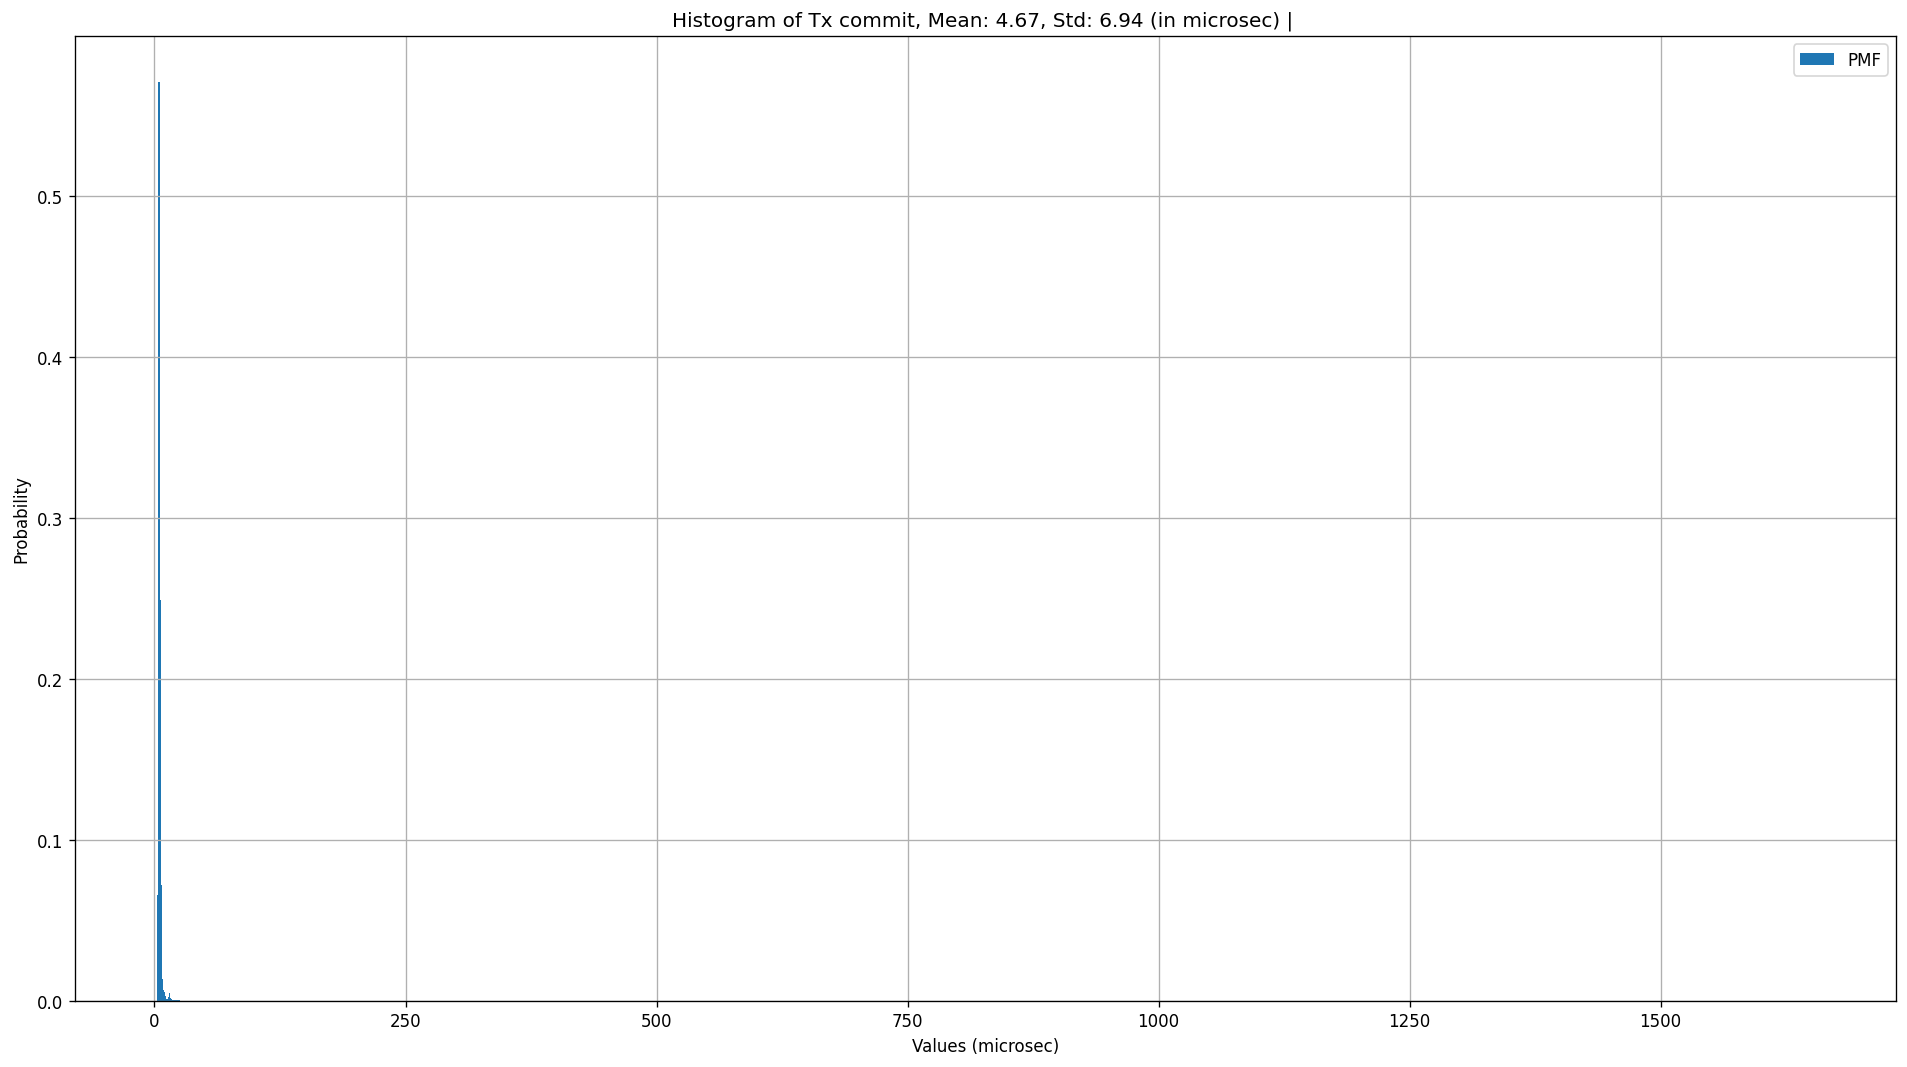

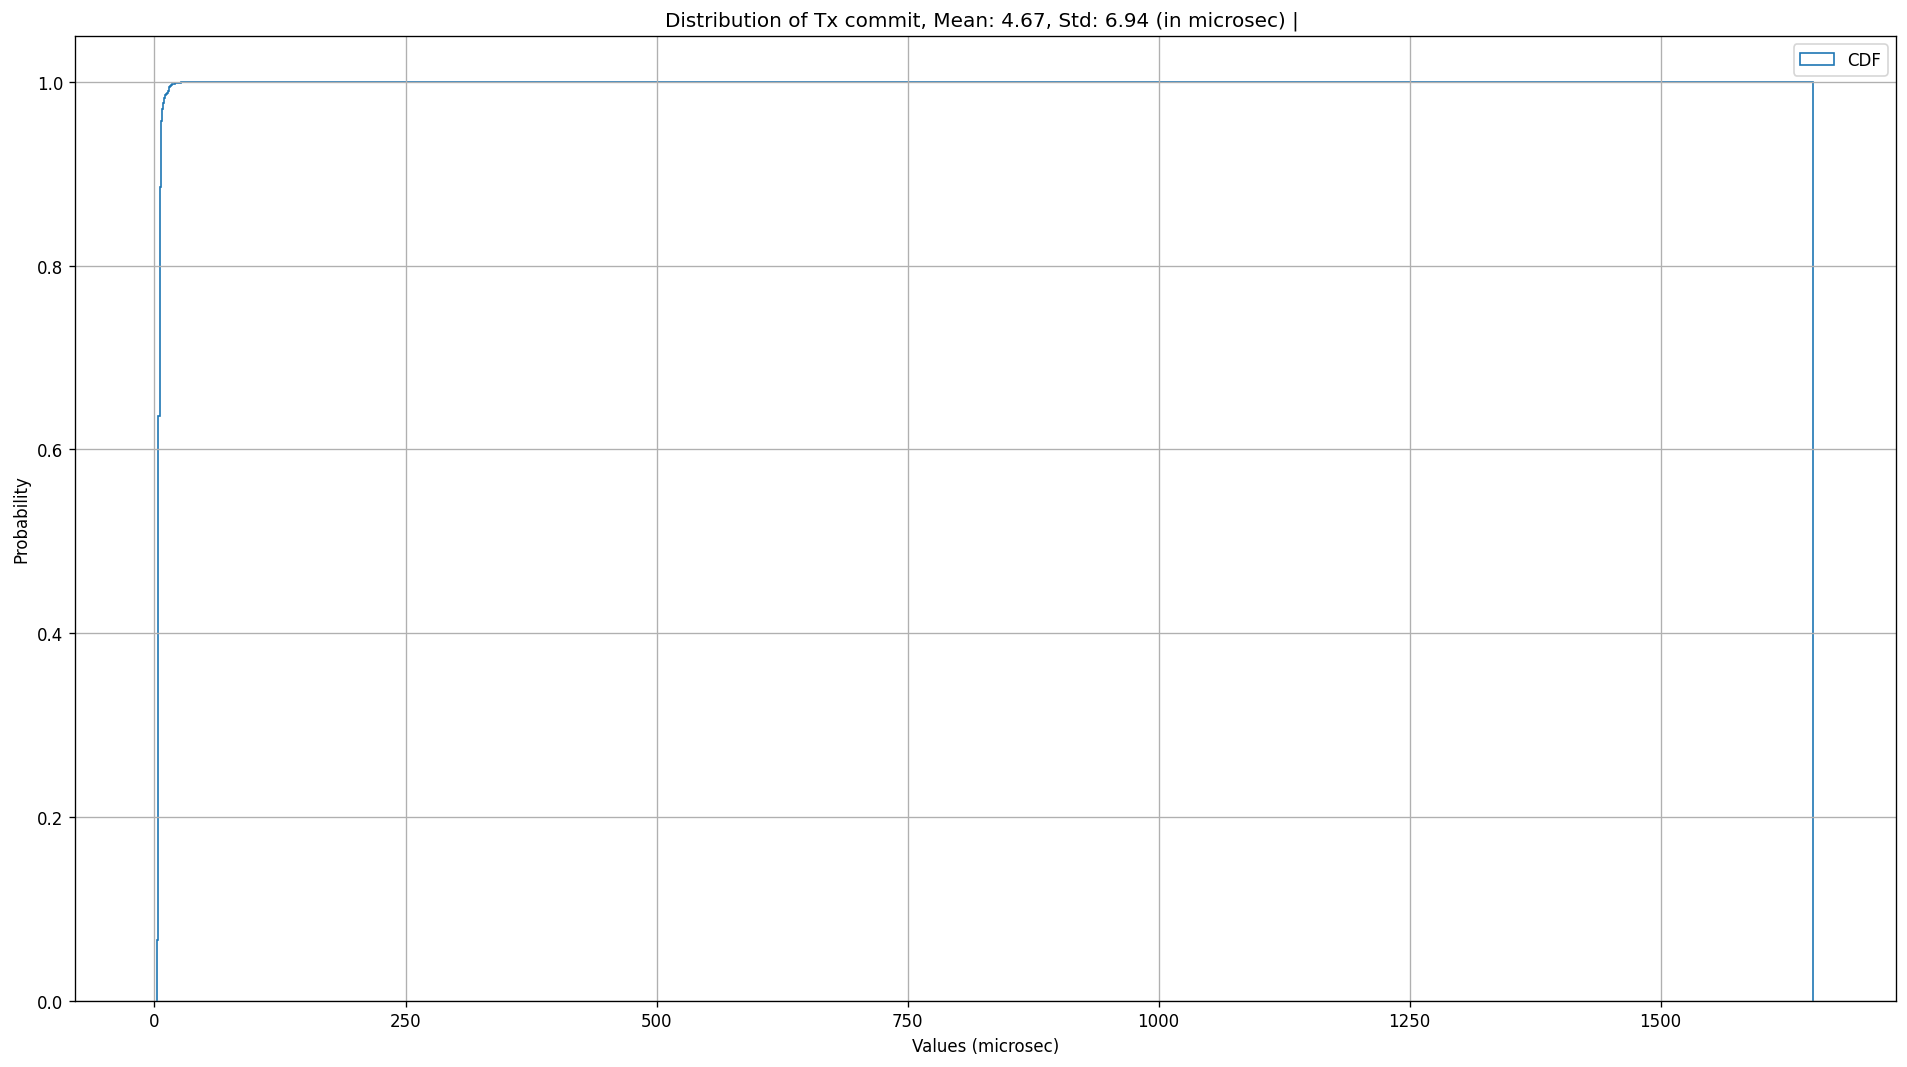

feature_warmup shape: (116400, 14)


,Num of reads,Num of writes,Num of active txs,Thread pool size,CPU utilization,Num of cache read,Num of cache insert,Num of cache update,Num of arithmetic operations,Num of write record,Num of bytes,Num of read write record,Num of log flush bytes,Num of Threads
0,10,0,1,50,0.0,20,0,0,0,0,0,10,0,22
1,10,0,1,50,0.0,20,0,0,0,0,0,10,0,25
2,10,0,1,50,1.0,20,0,0,0,0,0,10,0,26
3,10,0,1,50,3.0,20,0,0,0,0,0,10,0,27
4,10,0,1,50,2.0,20,0,0,0,0,0,10,0,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116395,10,0,1,50,0.0,20,0,0,0,0,0,10,0,67
116396,10,0,1,50,0.0,20,0,0,0,0,0,10,0,67
116397,10,0,1,50,3.0,20,0,0,0,0,0,10,0,67
116398,10,0,1,50,0.0,20,0,0,0,0,0,10,0,67


target_warmup shape: (116400, 1)


,Tx commit
0,59868
1,186238
2,1651620
3,234159
4,201914
...,...
116395,4588
116396,4134
116397,4065
116398,4306


(116400,)
feature_outliner shape: (114883, 14)
target_outliner shape: (114883, 1)
In microsec, Number of bins: 10
Mean Latency: 4.45, Std Latency: 0.97 (microsec)


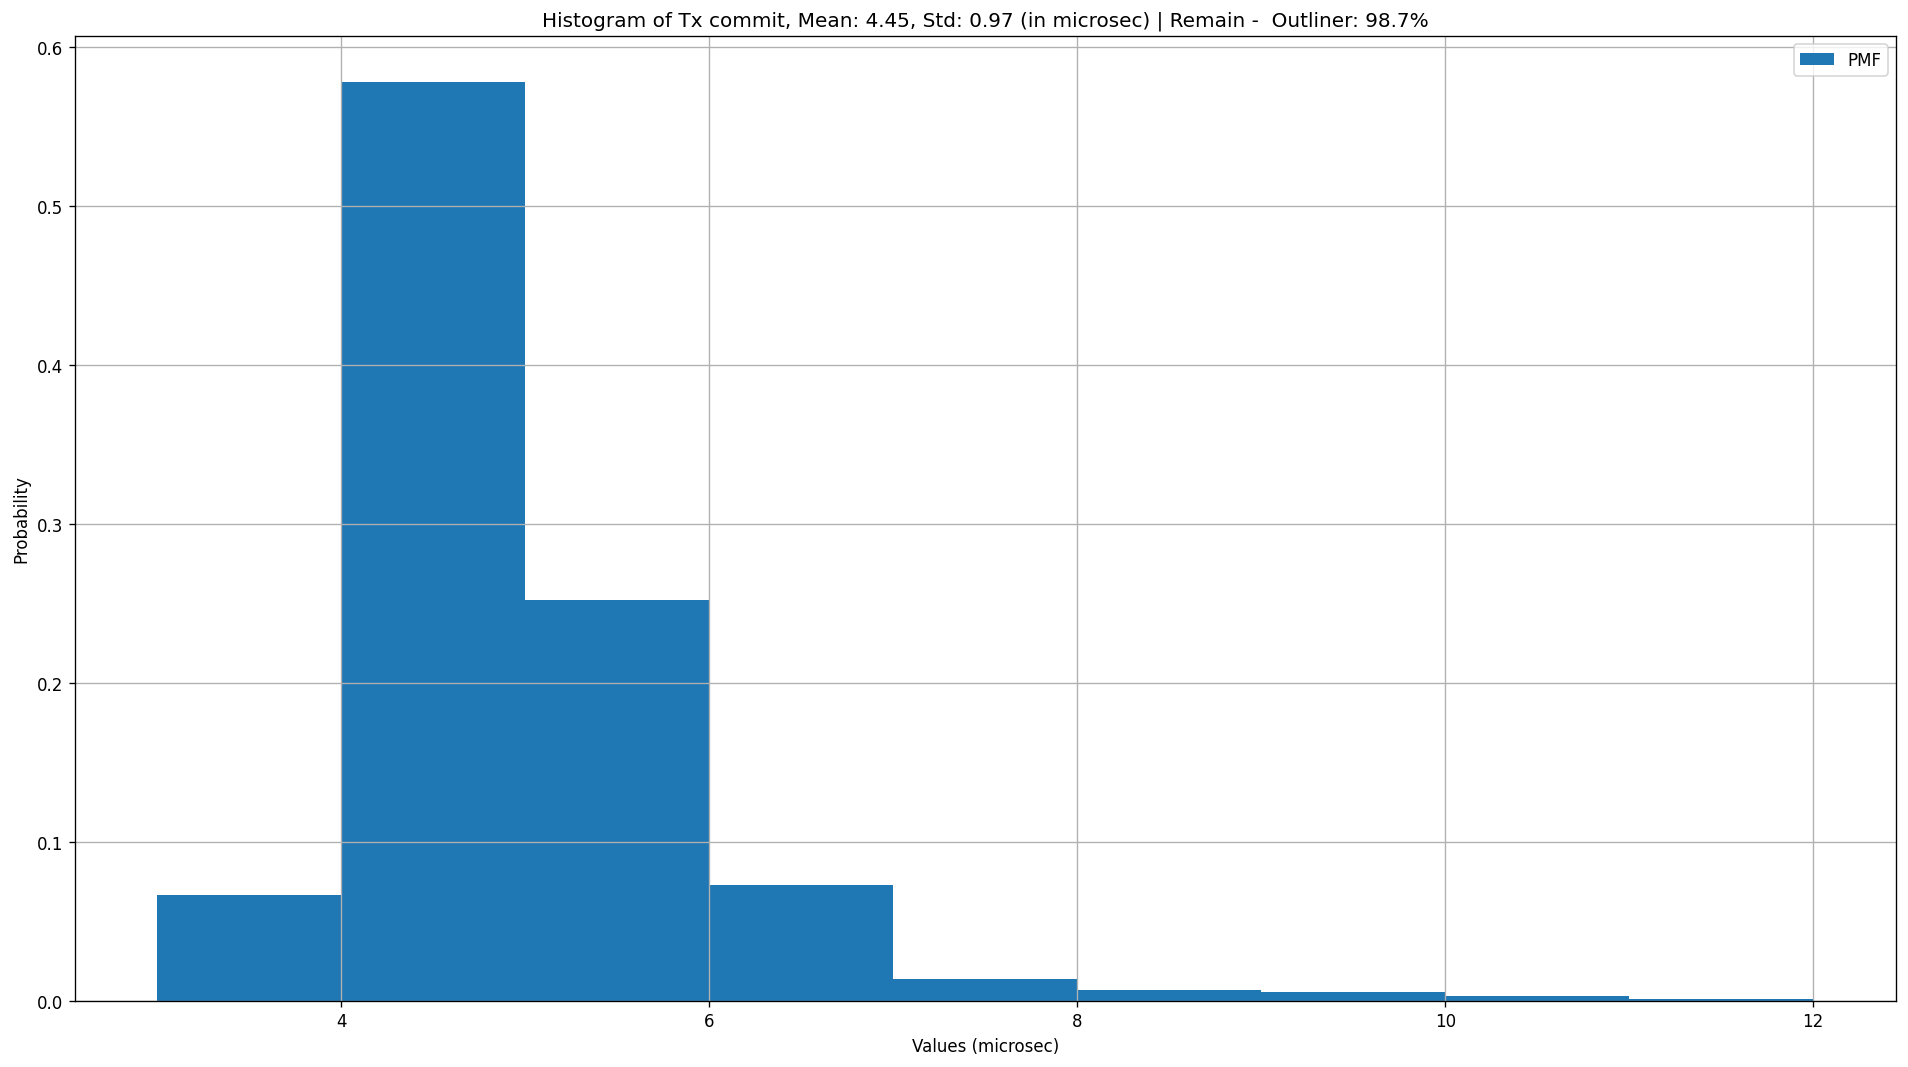

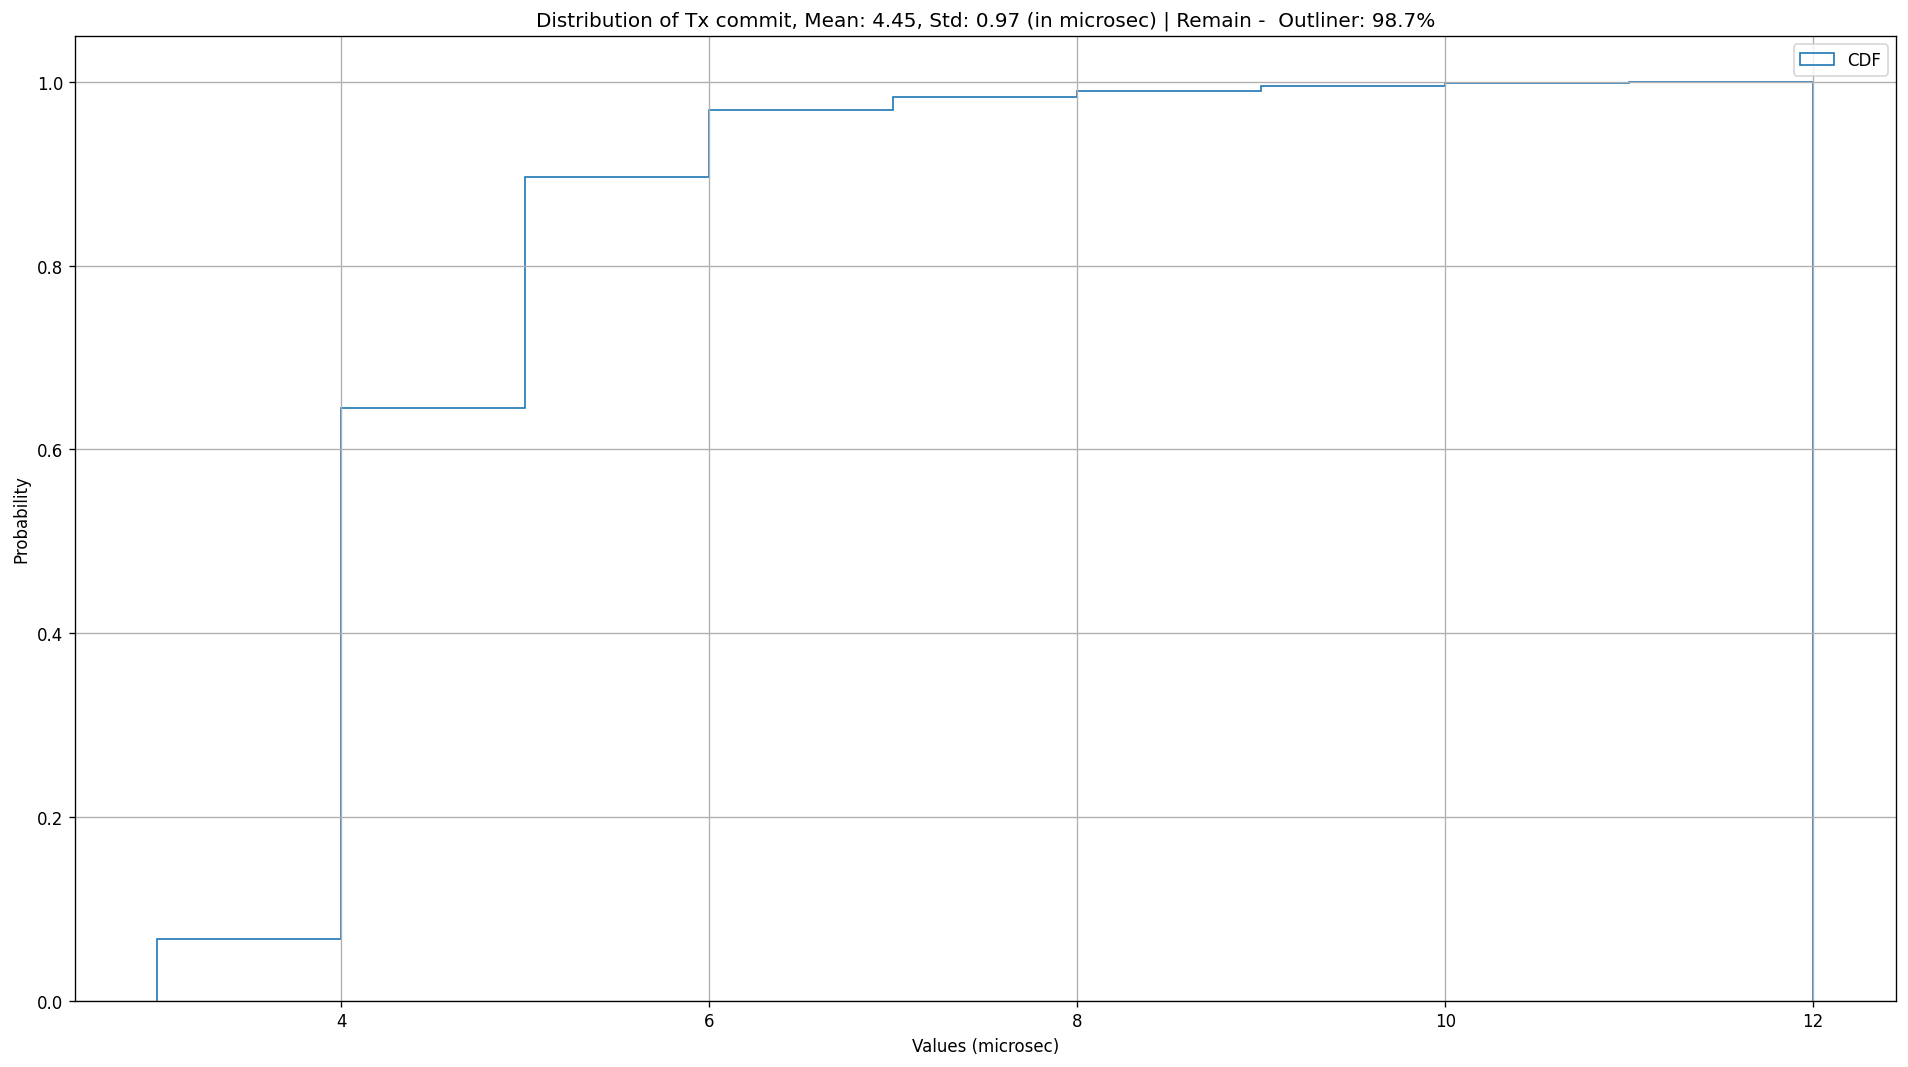

OU - Tx commit Features shape: (114883, 14)


,Num of reads,Num of writes,Num of active txs,Thread pool size,CPU utilization,Num of cache read,Num of cache insert,Num of cache update,Num of arithmetic operations,Num of write record,Num of bytes,Num of read write record,Num of log flush bytes,Num of Threads
0,10,0,1,50,0.0,20,0,0,0,0,0,10,0,67
1,10,0,1,50,3.0,20,0,0,0,0,0,10,0,67
2,10,0,1,50,3.0,20,0,0,0,0,0,10,0,67
3,10,0,1,50,6.0,20,0,0,0,0,0,10,0,67
4,10,0,1,50,3.0,20,0,0,0,0,0,10,0,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114878,10,0,1,50,0.0,20,0,0,0,0,0,10,0,67
114879,10,0,1,50,0.0,20,0,0,0,0,0,10,0,67
114880,10,0,1,50,3.0,20,0,0,0,0,0,10,0,67
114881,10,0,1,50,0.0,20,0,0,0,0,0,10,0,67


OU - Tx commit Targets shape: (114883, 1)


,Tx commit
0,10906
1,11215
2,11420
3,11166
4,10995
...,...
114878,4588
114879,4134
114880,4065
114881,4306


ValueError: ignored

In [194]:
for path in paths:
    rt.setPath(path=path)
    rt.buildDataset()
    for targetName in targetNames:
        rt.fit(featureNames=featureNames, targetName=targetName)